In [1]:
# Importing the Keras libraries and packages

from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Lambda ,Dense ,Flatten ,Dropout
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2

train_dir = "/kaggle/input/cnn-data/CNN data/train"
eval_dir = "/kaggle/input/cnn-data/CNN data/test"

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define preprocessing steps (including rescaling)
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,           # ← augmentations begin
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2         # ← splits train/val
)
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 9887 images belonging to 11 classes.
Found 2467 images belonging to 11 classes.


In [3]:
eval_datagen = ImageDataGenerator(rescale=1./255)

eval_generator = eval_datagen.flow_from_directory(
    eval_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 12354 images belonging to 11 classes.


In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Load VGG16 base
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classifier
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


58892288/58889256 [==============================] - 0s 0us/step


In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
checkpoint = ModelCheckpoint(
    'model_best.h5',
    monitor='val_loss',
    save_best_only=True,
    restore_best_weights=True
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_generator,
    epochs=80,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/80
114/309 [==========>...................] - ETA: 2:54 - loss: 1.9617 - accuracy: 0.3570

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


309/309 [==============================] - 325s 1s/step - loss: 1.6369 - accuracy: 0.4380 - val_loss: 1.1707 - val_accuracy: 0.6109
Epoch 2/80
309/309 [==============================] - 251s 812ms/step - loss: 1.2775 - accuracy: 0.5237 - val_loss: 1.0365 - val_accuracy: 0.6392
Epoch 3/80
309/309 [==============================] - 257s 830ms/step - loss: 1.1543 - accuracy: 0.5679 - val_loss: 0.9854 - val_accuracy: 0.6741
Epoch 4/80
309/309 [==============================] - 248s 801ms/step - loss: 1.0827 - accuracy: 0.5873 - val_loss: 1.1116 - val_accuracy: 0.6518
Epoch 5/80
309/309 [==============================] - 249s 806ms/step - loss: 1.0648 - accuracy: 0.5934 - val_loss: 0.9662 - val_accuracy: 0.6846
Epoch 6/80
309/309 [==============================] - 255s 824ms/step - loss: 1.0398 - accuracy: 0.6024 - val_loss: 0.9555 - val_accuracy: 0.6919
Epoch 7/80
309/309 [==============================] - 250s 809ms/step - loss: 1.0164 - accuracy: 0.6110 - val_loss: 0.9911 - val_accuracy:

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
# Saving the model of vgg16
model.save('model_vgg16.h5')

In [8]:
# Evaluate on eval set
eval_loss, eval_acc = model.evaluate(eval_generator, verbose=1)
print(f"\n✅ Evaluation Accuracy: {eval_acc:.4f} | Loss: {eval_loss:.4f}")


387/387 [==============================] - 206s 532ms/step - loss: 0.4718 - accuracy: 0.8592

✅ Evaluation Accuracy: 0.8592 | Loss: 0.4718


In [9]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions (probabilities)
y_pred_probs = model.predict(eval_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = eval_generator.classes
class_labels = list(eval_generator.class_indices.keys())

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



Classification Report:
                  precision    recall  f1-score   support

        aircraft       0.82      0.85      0.83      1205
       artillery       0.79      0.77      0.78      1190
      camouflage       0.87      0.94      0.91      1004
        civilian       0.91      0.86      0.88      1086
civilian vehicle       0.96      0.99      0.97      1170
military_vehicle       0.94      0.84      0.89      1110
         soldier       0.80      0.81      0.80      1064
            tank       0.75      0.52      0.62      1192
           truck       1.00      0.99      0.99      1118
         warship       0.72      0.98      0.83      1107
          weapon       0.92      0.94      0.93      1108

        accuracy                           0.86     12354
       macro avg       0.86      0.86      0.86     12354
    weighted avg       0.86      0.86      0.86     12354



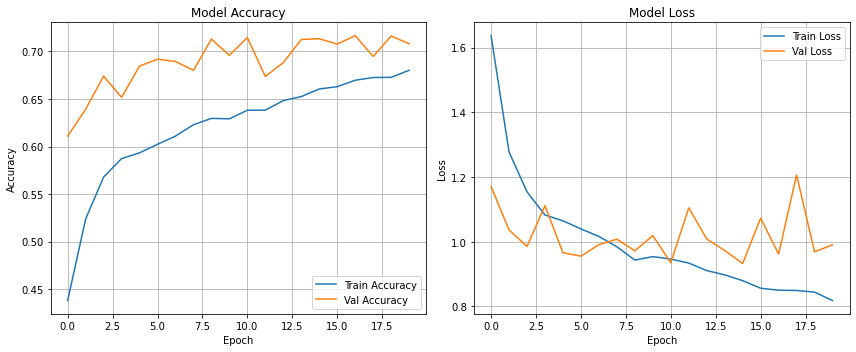

In [10]:
# Plot accuracy and loss from training
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


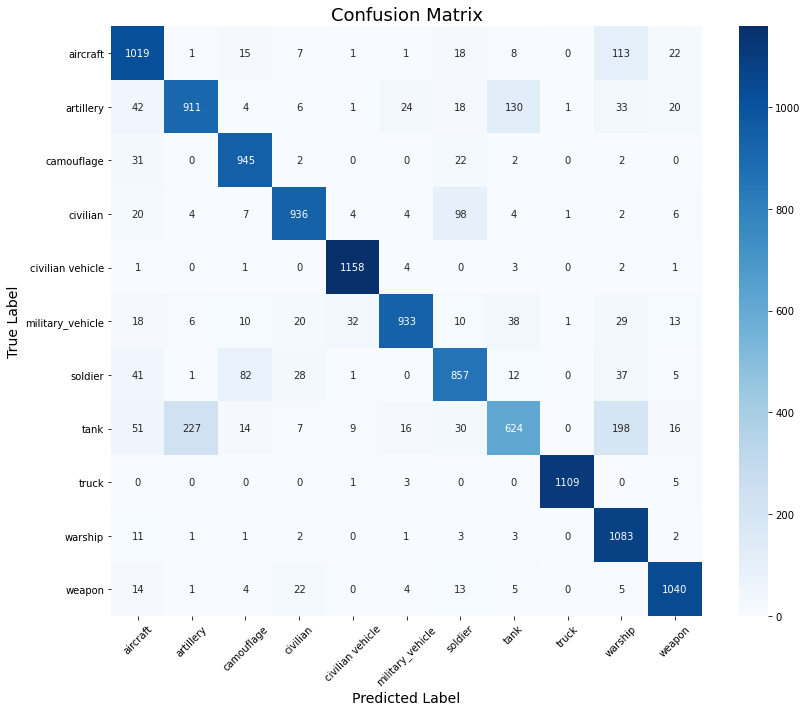

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get predictions
y_pred_probs = model.predict(eval_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = eval_generator.classes
class_labels = list(eval_generator.class_indices.keys())
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot using Seaborn heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,            # show numbers inside cells
    fmt='d',               # integer format
    cmap='Blues',          # color map
    xticklabels=class_labels,
    yticklabels=class_labels
)

# Titles and labels
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Show plot
plt.show()


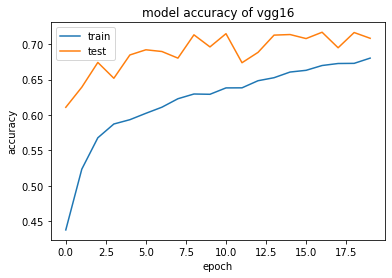

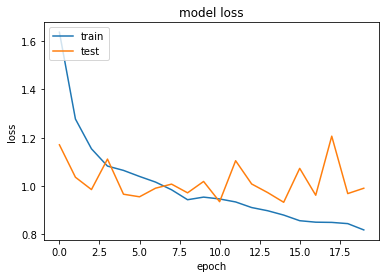

In [12]:
#vgg16
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy of vgg16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

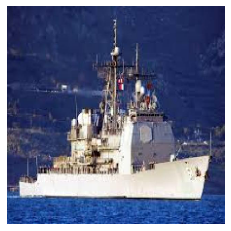

Predicted class: warship


In [13]:
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt

# List of your 11 classes (in the correct order from your training)
military_classes = ['aircraft', 'artillery', 'camouflage', 'civilian',
                    'civilian vehicle', 'military vehicle', 'soldier',
                    'tank', 'truck', 'warship', 'weapon']

# Load and preprocess image
img_path = '/kaggle/input/cnn-data/CNN data/test/warship/024182.jpg'  # Example
img = image.load_img(img_path, target_size=(224, 224))  # or (64,64) based on model
plt.imshow(img)
plt.axis('off')
plt.show()

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Predict with VGG16 model
predictions = model.predict(img_array)
predicted_class = military_classes[np.argmax(predictions[0])]

print(f"Predicted class: {predicted_class}")
